In [2]:
import skimage.io as io

# Show the figures / plots inside the notebook
%matplotlib inline
from skimage.color import rgb2gray,rgb2hsv, rgba2rgb
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.util import random_noise
import numpy as np
from commonfunctions import *
from skimage import io, color, morphology
from skimage.measure import label, regionprops
from skimage.draw import polygon
from skimage import transform
from skimage.morphology import binary_closing
from scipy import ndimage
from skimage.morphology import remove_small_objects


from skimage.exposure import histogram
from matplotlib.pyplot import bar

In [3]:
pip install opencv-python


Note: you may need to restart the kernel to use updated packages.


In [4]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans



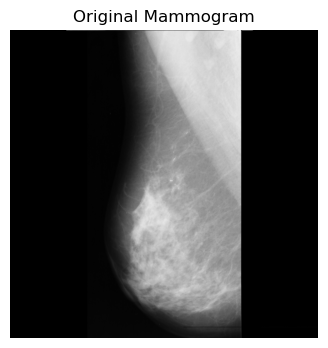

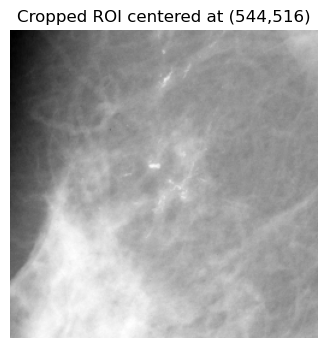

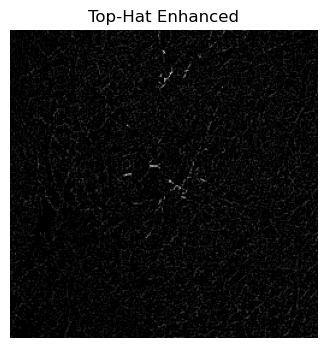

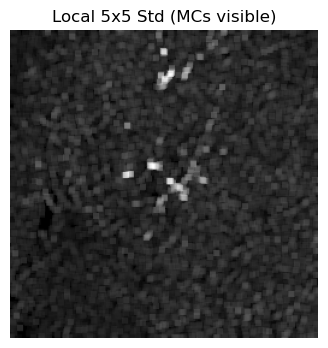

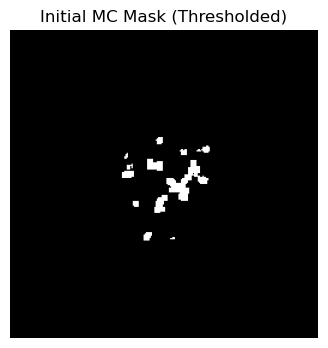

Detected 7 microcalcifications within search region


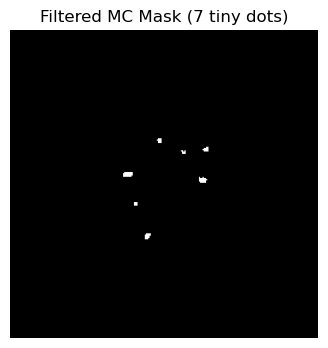

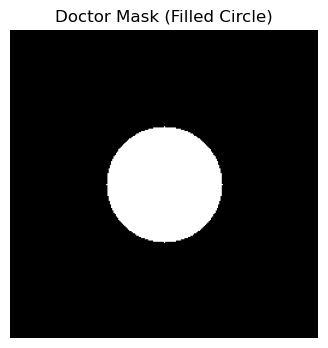


Detected MCs
Inside GT:    122 pixels (100.0%)
Outside GT:     0 pixels (  0.0%)
GOOD: Majority inside GT region!


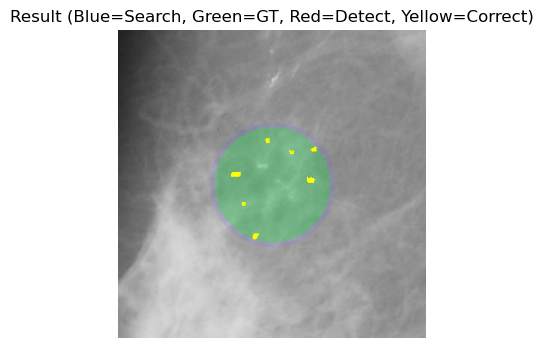

In [114]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Visualization helper
# -------------------------
def show(img, title, cmap='gray'):
    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

# -------------------------
# Load image
# -------------------------
def load_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Image not found")
    show(img, "Original Mammogram")
    return img

# -------------------------
# Crop ROI around (x, y)
# -------------------------
def image_crop(img, cx, cy, size=256):
    half = size // 2
    h, w = img.shape
    cy = h - cy 
    y1, y2 = cy - half, cy + half
    x1, x2 = cx - half, cx + half

    img_h, img_w = img.shape

    # Handle borders
    y1_pad = max(0, -y1)
    y2_pad = max(0, y2 - img_h)
    x1_pad = max(0, -x1)
    x2_pad = max(0, x2 - img_w)

    y1 = max(0, y1)
    y2 = min(img_h, y2)
    x1 = max(0, x1)
    x2 = min(img_w, x2)

    roi = img[y1:y2, x1:x2]

    # Pad if needed
    if y1_pad > 0 or y2_pad > 0 or x1_pad > 0 or x2_pad > 0:
        roi = cv2.copyMakeBorder(
            roi,
            y1_pad, y2_pad, x1_pad, x2_pad,
            cv2.BORDER_CONSTANT, value=0
        )

    show(roi, f"Cropped ROI centered at ({cx},{cy})")
    return roi

# -------------------------
# Top-hat enhancement (YOUR ORIGINAL)
# -------------------------
def tophat_transform(img):
    se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    opened = cv2.morphologyEx(img, cv2.MORPH_OPEN, se)
    enhanced = cv2.subtract(img, opened)
    show(enhanced,"Top-Hat Enhanced")
    return enhanced

# -------------------------
# Local 5x5 mean/std (YOUR ORIGINAL)
# -------------------------
def local_5x5_std(img):
    kernel = np.ones((5,5),np.float32)/25
    mean = cv2.filter2D(img.astype(np.float32),-1,kernel)
    sqr = img.astype(np.float32)**2
    mean_sqr = cv2.filter2D(sqr,-1,kernel)
    std = np.sqrt(np.maximum(mean_sqr - mean**2,0))
    show(std,"Local 5x5 Std (MCs visible)")
    return std

# # -------------------------
# # CRITICAL: Create search region mask
# # -------------------------
def create_search_region(shape, center_x, center_y, radius):
    """Only search within and slightly around the GT region"""
    mask = np.zeros(shape, np.uint8)
    # TIGHTER: Search in area 1.1x the GT radius (only 10% larger)
    search_radius = int(radius * 1.1)
    cv2.circle(mask, (center_x, center_y), search_radius, 255, -1)
    return mask

# -------------------------
# Detect MCs ONLY within search region
# -------------------------
def detect_mcs(std_img, search_mask):
    # Apply search mask first
    std_masked = cv2.bitwise_and(std_img, std_img, mask=search_mask)
    
    std_norm = cv2.normalize(std_masked, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    # Get threshold ONLY from search region pixels
    search_pixels = std_norm[search_mask > 0]
    if len(search_pixels) == 0:
        return np.zeros_like(std_norm)
    
    # Use 90th percentile of search region (moderately high threshold)
    thresh_val = np.percentile(search_pixels, 90)
    
    
    mask = (std_norm >= thresh_val).astype(np.uint8) * 255
    show(mask, "Initial MC Mask (Thresholded)")
    
    # Apply search region again to be extra sure
    mask = cv2.bitwise_and(mask, mask, mask=search_mask)
    
    
    # AGGRESSIVE EROSION: Heavily shrink detected regions
    kernel_erode = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.erode(mask, kernel_erode, iterations=1)
    
    
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)
    filtered = np.zeros_like(mask)
    mc_count = 0
    
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        width = stats[i, cv2.CC_STAT_WIDTH]
        height = stats[i, cv2.CC_STAT_HEIGHT]
        
        # Check aspect ratio
        aspect_ratio = max(width, height) / (min(width, height) + 1e-10)
        
        # Filter: small area, roughly circular
        if 4 <= area <= 35 and aspect_ratio < 2.8:
            filtered[labels == i] = 255
            mc_count += 1
    
    print(f"Detected {mc_count} microcalcifications within search region")
    show(filtered, f"Filtered MC Mask ({mc_count} tiny dots)")
    return filtered

# -------------------------
# Doctor mask
# -------------------------
def doctor_mask(shape, radius):
    mask = np.zeros(shape, np.uint8)
    c = shape[0] // 2
    cv2.circle(mask, (c, c), radius, 255, -1)
    show(mask, "Doctor Mask (Filled Circle)")
    return mask



# -------------------------
# Detection analysis
# -------------------------
def analyze_detections(pred_mask, gt_mask):
    inside = np.sum((pred_mask > 0) & (gt_mask > 0))
    outside = np.sum((pred_mask > 0) & (gt_mask == 0))
    total = inside + outside
    
    print("\n" + "="*60)
    print("Detected MCs")
    print("="*60)
    if total > 0:
        print(f"Inside GT:  {inside:5d} pixels ({inside/total*100:5.1f}%)")
        print(f"Outside GT: {outside:5d} pixels ({outside/total*100:5.1f}%)")
        if inside > outside:
            print("GOOD: Majority inside GT region!")
        else:
            print("BAD: Majority outside GT region!")
    else:
        print("No detections!")
    print("="*60)

# -------------------------
# Full pipeline
# -------------------------
def run_single_image(image_path, x, y, radius):
    img = load_image(image_path)
    roi = image_crop(img, x, y)
    
    # YOUR original methods
    enhanced = tophat_transform(roi)
    std = local_5x5_std(enhanced)
    
    # NEW: Create search region centered at ROI center
    center = roi.shape[0] // 2
    search_mask = create_search_region(std.shape, center, center, radius)
    
    # Detect ONLY within search region
    pred_mask = detect_mcs(std, search_mask)
    
    # Doctor mask
    gt_mask = doctor_mask(pred_mask.shape, radius)
    
    # Analysis
    analyze_detections(pred_mask, gt_mask)
    
   
    # Overlay
    overlay = cv2.cvtColor(roi, cv2.COLOR_GRAY2RGB)
    
    # Show search region in blue (faint)
    search_vis = overlay.copy()
    search_vis[search_mask > 0] = [100, 100, 255]
    overlay = cv2.addWeighted(overlay, 0.85, search_vis, 0.15, 0)
    
    # Show GT in green (semi-transparent)
    gt_vis = overlay.copy()
    gt_vis[gt_mask > 0] = [0, 255, 0]
    overlay = cv2.addWeighted(overlay, 0.75, gt_vis, 0.25, 0)
    
    # Detections in red
    overlay[pred_mask > 0] = [255, 0, 0]
    
    # Correct detections in yellow
    overlap = (pred_mask > 0) & (gt_mask > 0)
    overlay[overlap] = [255, 255, 0]
    
    show(overlay, "Result (Blue=Search, Green=GT, Red=Detect, Yellow=Correct)")
    
    return pred_mask, gt_mask

# =====================================================
# RUN
# =====================================================
if __name__ == "__main__":
    IMAGE_PATH = "Dataset/all-mias/mdb249.pgm"
    X = 544
    Y = 508
    R = 48
    
    
    
    run_single_image(IMAGE_PATH, X, Y, R)

In [98]:
import pandas as pd
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt

# ------------------------- Helper: save overlay without showing -------------------------
def save_image(img, save_path):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.imsave(save_path, img)

# ------------------------- Load image -------------------------
def load_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image not found: {path}")
    return img

# ------------------------- Crop ROI -------------------------
def image_crop(img, cx, cy, size=256):
    half = size // 2
    h, w = img.shape
    cy = h - cy  # flip Y if needed
    y1, y2 = cy - half, cy + half
    x1, x2 = cx - half, cx + half

    y1_pad = max(0, -y1)
    y2_pad = max(0, y2 - h)
    x1_pad = max(0, -x1)
    x2_pad = max(0, x2 - w)

    y1 = max(0, y1)
    y2 = min(h, y2)
    x1 = max(0, x1)
    x2 = min(w, x2)

    roi = img[y1:y2, x1:x2]
    if y1_pad > 0 or y2_pad > 0 or x1_pad > 0 or x2_pad > 0:
        roi = cv2.copyMakeBorder(
            roi, y1_pad, y2_pad, x1_pad, x2_pad,
            cv2.BORDER_CONSTANT, value=0
        )
    return roi

# ------------------------- Top-hat enhancement -------------------------
def tophat_transform(img):
    se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    opened = cv2.morphologyEx(img, cv2.MORPH_OPEN, se)
    return cv2.subtract(img, opened)

# ------------------------- Local 5x5 std -------------------------
def local_5x5_std(img):
    kernel = np.ones((5, 5), np.float32)/25
    mean = cv2.filter2D(img.astype(np.float32), -1, kernel)
    sqr = img.astype(np.float32)**2
    mean_sqr = cv2.filter2D(sqr, -1, kernel)
    return np.sqrt(np.maximum(mean_sqr - mean**2, 0))

# ------------------------- Create search region -------------------------
def create_search_region(shape, center_x, center_y, radius):
    mask = np.zeros(shape, np.uint8)
    search_radius = int(radius * 1.1)
    cv2.circle(mask, (center_x, center_y), search_radius, 255, -1)
    return mask

# ------------------------- Detect MCs -------------------------
def detect_mcs(std_img, search_mask):
    std_masked = cv2.bitwise_and(std_img, std_img, mask=search_mask)
    std_norm = cv2.normalize(std_masked, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    search_pixels = std_norm[search_mask > 0]
    if len(search_pixels) == 0:
        return np.zeros_like(std_norm)
    thresh_val = np.percentile(search_pixels, 90)
    mask = (std_norm >= thresh_val).astype(np.uint8) * 255
    mask = cv2.bitwise_and(mask, mask, mask=search_mask)
    kernel_erode = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.erode(mask, kernel_erode, iterations=1)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)
    filtered = np.zeros_like(mask)
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        width = stats[i, cv2.CC_STAT_WIDTH]
        height = stats[i, cv2.CC_STAT_HEIGHT]
        aspect_ratio = max(width, height) / (min(width, height) + 1e-10)
        if 4 <= area <= 35 and aspect_ratio < 2.8:
            filtered[labels == i] = 255
    return filtered

# ------------------------- Doctor GT mask -------------------------
def doctor_mask(shape, radius):
    mask = np.zeros(shape, np.uint8)
    c = shape[0] // 2
    cv2.circle(mask, (c, c), radius, 255, -1)
    return mask

# ------------------------- Analyze detections -------------------------
def analyze_detections(pred_mask, gt_mask):
    inside = np.sum((pred_mask > 0) & (gt_mask > 0))
    outside = np.sum((pred_mask > 0) & (gt_mask == 0))
    total = inside + outside
    return {
        'inside_pixels': inside,
        'outside_pixels': outside,
        'total_detected_pixels': total,
        'inside_percent': inside / (total + 1e-10) * 100 if total > 0 else 0,
        'outside_percent': outside / (total + 1e-10) * 100 if total > 0 else 0
    }

# ------------------------- Process a single image -------------------------
def process_and_save_image(row, output_dir="output_visualizations"):
    path = row['PATH']
    x = row['X']
    y = row['Y']
    radius = row['RADIUS']
    
    if pd.isna(x) or pd.isna(y):
        return None
    
    x = int(x)
    y = int(y)
    radius = int(radius)
    
    try:
        img = load_image(path)
        roi = image_crop(img, x, y)
        enhanced = tophat_transform(roi)
        std = local_5x5_std(enhanced)
        center = roi.shape[0] // 2
        search_mask = create_search_region(std.shape, center, center, radius)
        pred_mask = detect_mcs(std, search_mask)
        gt_mask = doctor_mask(pred_mask.shape, radius)
        
        metrics = analyze_detections(pred_mask, gt_mask)  # metrics ONLY from analyze_detections

        # Visualization overlay (saved, not shown)
        overlay = cv2.cvtColor(roi, cv2.COLOR_GRAY2RGB)
        search_vis = overlay.copy()
        search_vis[search_mask > 0] = [100, 100, 255]
        overlay = cv2.addWeighted(overlay, 0.85, search_vis, 0.15, 0)
        gt_vis = overlay.copy()
        gt_vis[gt_mask > 0] = [0, 255, 0]
        overlay = cv2.addWeighted(overlay, 0.75, gt_vis, 0.25, 0)
        overlay[pred_mask > 0] = [255, 0, 0]
        overlap = (pred_mask > 0) & (gt_mask > 0)
        overlay[overlap] = [255, 255, 0]

        filename = os.path.splitext(os.path.basename(path))[0]
        save_path = os.path.join(output_dir, f"{filename}_vis.png")
        save_image(overlay, save_path)
        
        return metrics
    except:
        return None

# ------------------------- Run pipeline on CSV -------------------------
def run_images_from_csv_with_saving(csv_path, output_dir="output_visualizations"):
    df = pd.read_csv(csv_path)
    df = df[df['TYPE'] == 'MICRO_CALCIFICATION']
    
    all_metrics = []
    
    for idx, row in df.iterrows():
        metrics = process_and_save_image(row, output_dir)
        if metrics:
            # Output result of every image ONLY
            filename = os.path.basename(row['PATH'])
            print(f"{filename}: inside={metrics['inside_pixels']}, "
                  f"outside={metrics['outside_pixels']}, "
                  f"total={metrics['total_detected_pixels']}, "
                  f"inside%={metrics['inside_percent']:.2f}, "
                  f"outside%={metrics['outside_percent']:.2f}")
            all_metrics.append(metrics)
    
    # Compute final averages
    if all_metrics:
        avg_metrics = {}
        for key in all_metrics[0].keys():
            avg_metrics[key] = np.mean([m[key] for m in all_metrics])
        print("\nAVERAGE METRICS OVER ALL IMAGES")
        for k, v in avg_metrics.items():
            print(f"{k:20s}: {v:.2f}")
        return avg_metrics
    else:
        print("No images processed.")
        return None

# ------------------------- Example usage -------------------------
csv_file = "train_dataset.csv"
run_images_from_csv_with_saving(csv_file, output_dir="visualizations")


mdb240.pgm: inside=71, outside=11, total=82, inside%=86.59, outside%=13.41
mdb231.pgm: inside=148, outside=13, total=161, inside%=91.93, outside%=8.07
mdb239.pgm: inside=172, outside=2, total=174, inside%=98.85, outside%=1.15
mdb223.pgm: inside=0, outside=0, total=0, inside%=0.00, outside%=0.00
mdb256.pgm: inside=86, outside=9, total=95, inside%=90.53, outside%=9.47
mdb249.pgm: inside=122, outside=0, total=122, inside%=100.00, outside%=0.00
mdb219.pgm: inside=47, outside=0, total=47, inside%=100.00, outside%=0.00
mdb211.pgm: inside=21, outside=0, total=21, inside%=100.00, outside%=0.00
mdb214.pgm: inside=6, outside=0, total=6, inside%=100.00, outside%=0.00
mdb238.pgm: inside=34, outside=0, total=34, inside%=100.00, outside%=0.00
mdb239.pgm: inside=87, outside=6, total=93, inside%=93.55, outside%=6.45
mdb241.pgm: inside=85, outside=0, total=85, inside%=100.00, outside%=0.00
mdb252.pgm: inside=47, outside=1, total=48, inside%=97.92, outside%=2.08
mdb253.pgm: inside=77, outside=0, total=7

{'inside_pixels': np.float64(96.95454545454545),
 'outside_pixels': np.float64(7.0),
 'total_detected_pixels': np.float64(103.95454545454545),
 'inside_percent': np.float64(92.49943060606189),
 'outside_percent': np.float64(2.955114848021126)}

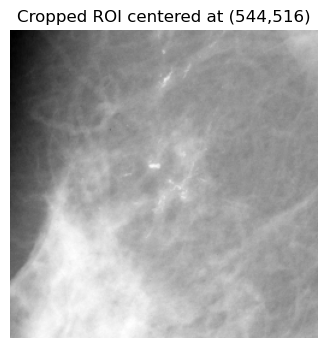

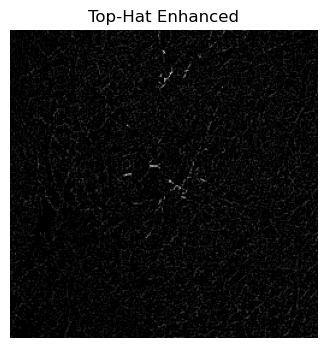

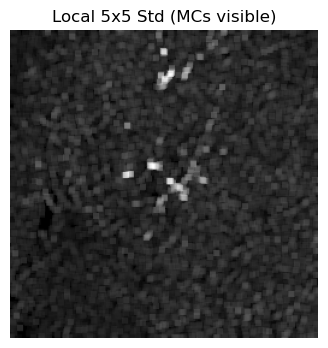

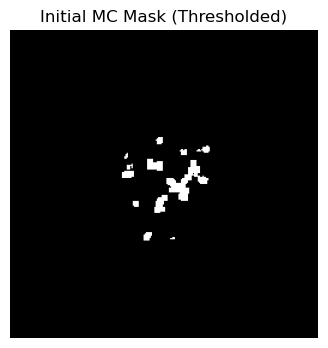

Detected 7 microcalcifications within search region


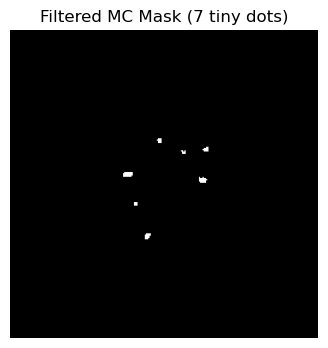

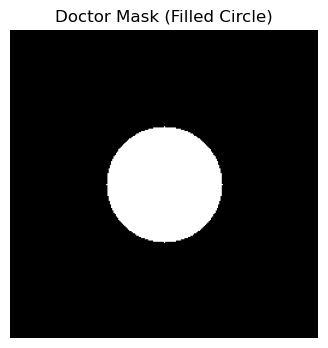

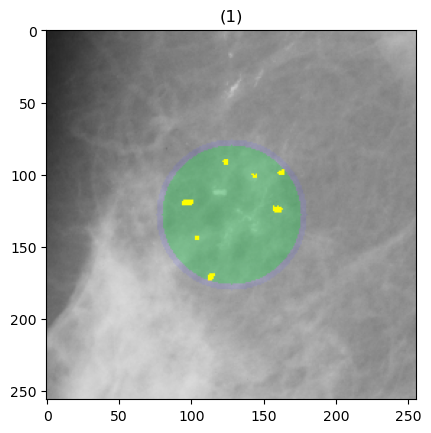

In [ ]:
def get_mc_data(image_path, x, y, radius, roi_size=256):
    
    # -------------------------
    # Load image
    # -------------------------
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image not found: {image_path}")

    # -------------------------
    # Crop ROI (SAME logic)
    # -------------------------
    roi = image_crop(img, x, y, size=roi_size)

    if roi is None or roi.size == 0:
        return [], None, None

    # -------------------------
    # Same processing pipeline
    # -------------------------
    tophat_norm = tophat_transform(roi)
    std = local_5x5_std(tophat_norm)

    center = roi.shape[0] // 2
    search_mask = create_search_region(std.shape, center, center, radius)

    pred_mask = detect_mcs(std, search_mask)
    gt_mask = doctor_mask(pred_mask.shape, radius)

    # -------------------------
    # Extract contours
    # -------------------------
    contours, _ = cv2.findContours(
        pred_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    # -------------------------
    # Build overlay (IDENTICAL)
    # -------------------------
    overlay = cv2.cvtColor(roi, cv2.COLOR_GRAY2RGB)

    # Blue: search region
    search_vis = overlay.copy()
    search_vis[search_mask > 0] = [100, 100, 255]
    overlay = cv2.addWeighted(overlay, 0.85, search_vis, 0.15, 0)

    # Green: GT
    gt_vis = overlay.copy()
    gt_vis[gt_mask > 0] = [0, 255, 0]
    overlay = cv2.addWeighted(overlay, 0.75, gt_vis, 0.25, 0)

    # Red: detections
    overlay[pred_mask > 0] = [255, 0, 0]

    # Yellow: correct detections
    overlap = (pred_mask > 0) & (gt_mask > 0)
    overlay[overlap] = [255, 255, 0]

    return contours, tophat_norm, overlay

contours, tophat, overlay = get_mc_data(
    image_path="Dataset/all-mias/mdb249.pgm",
    x=544,
    y=508,
    radius=48
)

show_images([overlay])
